## Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

In [3]:
PATH = "/home/nbuser/courses/fastai/courses/ml1/data/bulldozers/"

In [4]:
!ls {PATH}

'ls' is not recognized as an internal or external command,
operable program or batch file.


## The Data

In [4]:
# data = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=['saledate'])
data = pd.read_csv('Train.csv', low_memory=False, parse_dates=['saledate'])

### Looking at the data

In [5]:
data.shape

(401125, 53)

In [6]:
data.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [7]:
# Context manager to temporarily set options in the with statement context
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [8]:
display_all(data.head(2))

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


In [9]:
# display_all(data.describe(include='all').T).head()

In [10]:
# Transform SalePrice to log to comply with Kaggle evaluation
data['SalePrice'] = np.log(data['SalePrice'] )

In [11]:
data.SalePrice.head()

0    11.097410
1    10.950807
2     9.210340
3    10.558414
4     9.305651
Name: SalePrice, dtype: float64

### Initial Processing

In [12]:
# Extracting date attributes from saledate and dropping original column
def datetransform(df, fldname, drop=True):
    fld = df[fldname]
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Is_month_end', 'Is_month_start', 'Is_quarter_end', \
              'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df['Sales_'+n] = getattr(fld.dt, n.lower())
    df["Sales_"+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop:
        df = df.drop(fldname, axis=1, inplace=True)

In [13]:
datetransform(data, 'saledate')

In [14]:
data.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'Sales_Year', 'Sales_Month',
       'Sales_Week', 'Sales_Day', 'Sales_Dayofweek', 'Sales_

In [15]:
def catconv(df):
    for n in df:
        if df[n].dtypes == object:
            df[n] = df[n].astype('category')

In [16]:
# Convert object to categorical variable
catconv(data)

In [17]:
data.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [18]:
# This is how much of a varaible is null 
data.isnull().sum().sort_index()/len(data)*100

Backhoe_Mounting            80.387161
Blade_Extension             93.712932
Blade_Type                  80.097725
Blade_Width                 93.712932
Coupler                     46.662013
Coupler_System              89.165971
Differential_Type           82.695918
Drive_System                73.982923
Enclosure                    0.081022
Enclosure_Type              93.712932
Engine_Horsepower           93.712932
Forks                       52.115425
Grouser_Tracks              89.189903
Grouser_Type                75.281271
Hydraulics                  20.082269
Hydraulics_Flow             89.189903
MachineHoursCurrentMeter    64.408850
MachineID                    0.000000
ModelID                      0.000000
Pad_Type                    80.271985
Pattern_Changer             75.265067
ProductGroup                 0.000000
ProductGroupDesc             0.000000
ProductSize                 52.545964
Pushblock                   93.712932
Ride_Control                62.952696
Ripper      

In [19]:
os.makedirs('tmp', exist_ok=True)
# data.to_feather('tmp/bulldozers-raw')

### Preprocessing

In [20]:
# df_raw = pd.read_feather('tmp/bulldozers-raw')
df_raw = data

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [21]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+"_na"] = pd.isnull(col)
            filler = col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [22]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat is None or col.nunique() > max_n_cat):
        df[name] = col.cat.codes+1

In [23]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler

def scale_vars(df, mapper):
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

In [24]:
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [25]:
def proc_df(df, y_fld, skip_flds=None, do_scale=False, na_dict=None, max_n_cat=None, subset=None, mapper=None):
   
    if not skip_flds:
        skip_flds = []
    if subset:
        df = get_sample(df, subset)
    df = df.copy()
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis =1, inplace=True)
    
    if na_dict is None:
        na_dict = {}
    for n,c in df.items():
        na_dict = fix_missing(df, c, n, na_dict)
    if do_scale:
        mapper = scale_vars(df, mapper)
    for n,c in df.items():
        numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na = True), y, na_dict]
    if do_scale:
        res = res + [mapper]
    return res
        

In [26]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [27]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df, y)

0.9831657720498996

R-squared of 0.98? Are we overfitting the data, the best way is to seperate out data into training and validation

In [28]:
len(df)

401125

In [29]:
def split_data(df, n):
    return df[0:n].copy(), df[n:].copy()

In [30]:
n_valid = 12000 # Same as Kaggle's test set
n_trn = len(df)-n_valid

raw_train, raw_valid = split_data(df_raw, n_trn) #Splitting the raw data
X_train, X_valid = split_data(df, n_trn)
y_train, y_valid = split_data(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape, 

((389125, 66), (389125,), (12000, 66))

# Random Forest

## Base Model

In [31]:
import math
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

In [32]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
    m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [33]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 17.9 s
[0.09052289266868697, 0.2520485280482559, 0.9828741682539627, 0.8865469162078469]


## Speeding things up

In [34]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset= 30000, na_dict=nas)

X_train, _ = split_data(df_trn, 20000) # Use _ cuz I dont want to chamge my validation set, rather I want to throw it away
y_train, _ = split_data(y_trn, 20000)

In [35]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 760 ms
[0.11195907724899545, 0.3480438053022919, 0.9726500262921128, 0.7836704780149717]


## Single tree

In [6]:
from sklearn.tree import export_graphviz

def draw_tree(t, df,  size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s)))

In [54]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5371269683343529, 0.5674541015387262, 0.3970396664995464, 0.424944908737197]


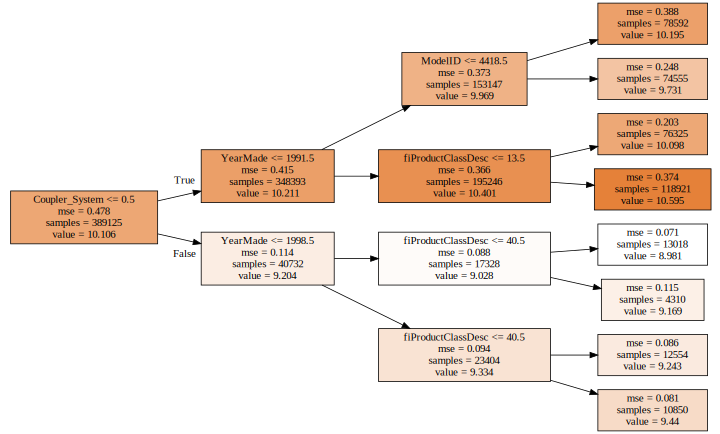

In [55]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [25]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[7.536443801682121e-17, 0.4797389301108064, 1.0, 0.5889847854047335]


## Bagging

### Intro to bagging

To learn about bagging in random forests, let's start with our basic model again.

In [26]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.11145979473450096, 0.3761791704270528, 0.9728049004634968, 0.7472812511888947]


We'll grab the predictions for each individual tree, and look at one example.

In [27]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([ 8.9872 , 10.12663,  9.3501 ,  9.6486 ,  9.25913,  9.10498,  9.25913,  8.9872 ,  9.90349,  9.21034]),
 9.383679121555486,
 9.104979856318357)

In [28]:
preds.shape

(10, 12000)

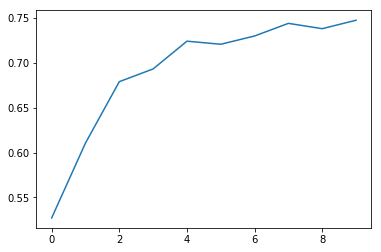

In [140]:
plt.plot([r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The number here at the 10th tree shall match the last score in the print_score:
[0.11145979473450096, 0.3761791704270528, 0.9728049004634968, 0.7472812511888947]

In [141]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10265366614849009, 0.37917387512054745, 0.9769323632747796, 0.7432415247018948]


In [142]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09392961472226918, 0.3699937827528779, 0.9806865768069059, 0.7555236647529878]


### Out-of-bag (OOB) score

In [145]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09647135727965261, 0.36401582773787355, 0.9796271891793586, 0.7633598079346455, 0.8529476095700255]


## Reducing over-fitting

In [17]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', na_dict=nas)
X_train, X_valid = split_data(df_trn, n_trn)
y_train, y_valid = split_data(y_trn, n_trn)

In [27]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11925551304473253, 0.22949470443593706, 0.9702770605813713, 0.9059425259598639, 0.9116323323225264]


# Random Forest Model interpretation

In [36]:
# df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [37]:
n_valid = 12000 # Same as Kaggle's test set
n_trn = len(df_trn)-n_valid

raw_train, raw_valid = split_data(df_raw, n_trn) #Splitting the raw data
X_train, X_valid = split_data(df_trn, n_trn)
y_train, y_valid = split_data(y_trn, n_trn)

Profiling to check which lines takes most time to get it to run faster

# Confidence based on tree variance

In [38]:
from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [39]:
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [40]:
# While bootstrapping, change Random Forest Sample to give every tree a random sample of max 50,000
set_rf_samples(50000)

We do the above because we dont want massivaly accurante RF, but which indicates the nature of relationship, but make it high enough and run in seconds

In [41]:
# reset_rf_samples()

In [42]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.20575283551900891, 0.2489572036409543, 0.9115237954251064, 0.8893128084182513]


In [43]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])# Concat 12,000 predictions for every tree each in a list of arrays 

In [44]:
preds[:,0] # This extract all 12000 predictions from the first tree

array([ 9.27476152,  9.14333733,  9.29086125,  8.98388637,  9.04141187,
        9.14056235,  9.13054719,  9.404036  ,  9.78766103,  9.258563  ,
        9.2573548 ,  9.11681103,  9.12854662,  9.23354213,  9.07640065,
        9.28248071, 10.25332752,  9.39704559,  9.16544874,  9.18064449,
        9.54450149, 10.41346689,  9.15812244,  9.23054858,  9.80751018,
        9.35045828,  9.04247443,  9.30912712,  9.27293217,  9.18826702,
        9.55186329,  9.16544874,  9.66804508,  9.41652648,  9.39636206,
        9.02520205,  9.05529183,  9.02000763,  9.12821436,  9.99820366])

In [45]:
np.mean(preds[:,0]), np.mean(y_valid)

(9.332245098650237, 10.024625319314138)

The mean of the prediction is 9.3 while the real validation set is 10 which is not bad for one tree

In [46]:
np.mean(preds), np.mean(y_valid)

(10.01067762743576, 10.024625319314138)

Much better mean for the 40 trees

Since Python runs in series, the below will help run in parallel on all cores to make it faster

In [47]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
def parallel_trees(m, fn, n_jobs=8):
    return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

In [48]:
def get_preds(t):
    return t.predict(X_valid)

if __name__ == '__parallel_trees__':
    preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

(9.332245098650237, 0.3224894385859736)

For every tree we are predicting 12,000, then getting mean and standard deviation

In [49]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)

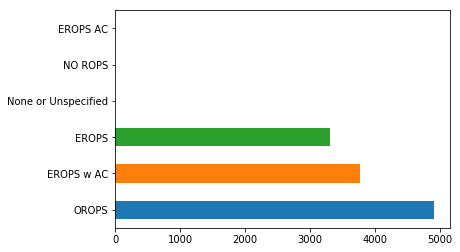

In [50]:
x.Enclosure.value_counts().plot.barh()

In [51]:
flds = ['Enclosure', 'SalePrice', 'pred_std', 'pred']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred_std,pred
0,EROPS,9.849178,0.272060,9.844179
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,0.264149,10.575775
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,0.223715,9.688404


In [52]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ

,Enclosure,SalePrice,pred_std,pred
0,EROPS,9.849178,0.272060,9.844179
2,EROPS w AC,10.623971,0.264149,10.575775
5,OROPS,9.682064,0.223715,9.688404


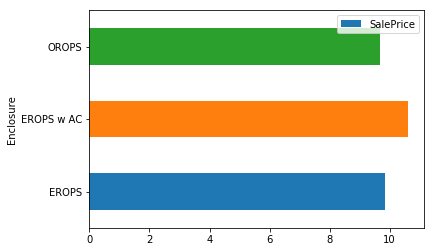

In [53]:
enc_summ.plot('Enclosure', 'SalePrice', 'barh')

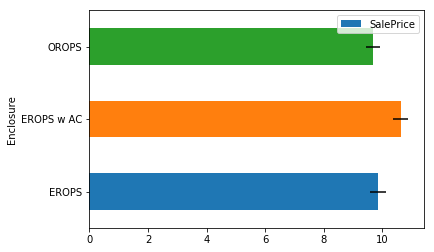

In [54]:
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xerr='pred_std')

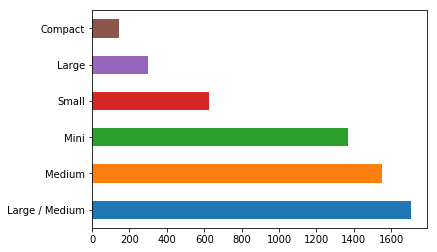

In [55]:
raw_valid.ProductSize.value_counts().plot.barh()

In [56]:
fld = ['ProductSize', 'SalePrice', 'pred_std', 'pred']
summ = x[fld].groupby(fld[0]).mean()
summ

,SalePrice,pred_std,pred
ProductSize,,,
Compact,9.735093,0.353621,9.866987
Large,10.470589,0.359173,10.385005
Large / Medium,10.691871,0.299265,10.649164
Medium,10.681511,0.287767,10.619854
Mini,9.535147,0.242993,9.565941
Small,10.324448,0.302791,10.336527


In [57]:
(summ.pred_std/summ.pred).sort_values(ascending = False)

ProductSize
Compact           0.035839
Large             0.034586
Small             0.029293
Large / Medium    0.028102
Medium            0.027097
Mini              0.025402
dtype: float64

# Feature Importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know how it's making predictions. The most important way to see this is with feature importance.

In [58]:
def rf_feat_imp(m, df):
    return pd.DataFrame({'Features': X_train.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [59]:
fi = rf_feat_imp(m, df_trn)
fi[:10]

,Features,imp
5,YearMade,0.171547
13,ProductSize,0.105737
37,Coupler_System,0.101406
14,fiProductClassDesc,0.082254
38,Grouser_Tracks,0.060141
2,ModelID,0.054904
63,Sales_Elapsed,0.050008
10,fiSecondaryDesc,0.046371
39,Hydraulics_Flow,0.039355
19,Enclosure,0.030487


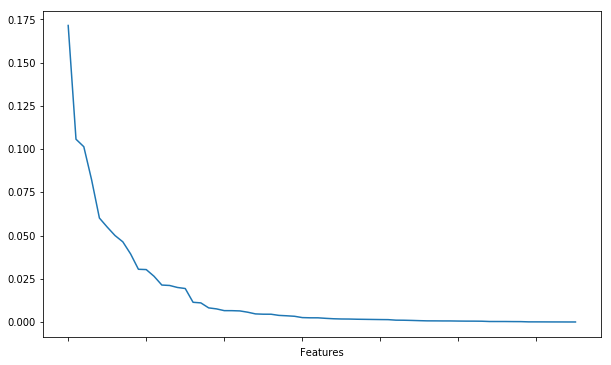

In [60]:
fi.plot('Features', "imp", figsize=(10,6), legend=False)

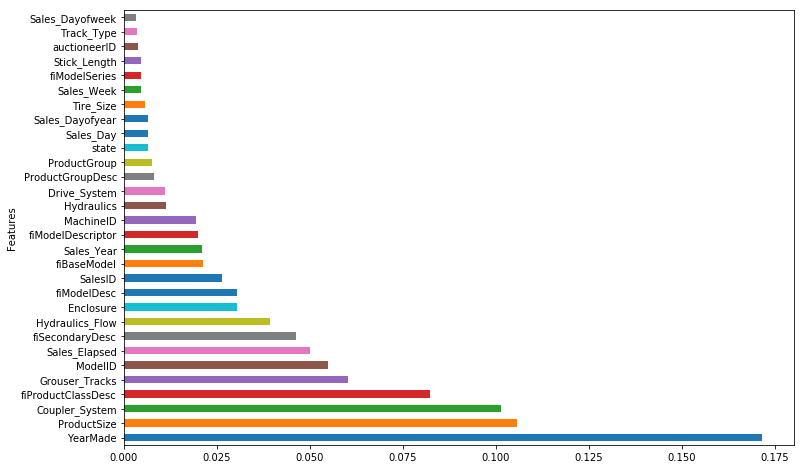

In [61]:
fi[:30].plot('Features', "imp", 'barh',figsize=(12,8), legend=False)

In [62]:
to_keep = fi[fi.imp > 0.005]
len(to_keep)

24

In [63]:
df_keep = df_trn[list(to_keep.Features)].copy()

In [64]:
X_train, X_valid = split_data(df_keep, n_trn)

In [65]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20715184633149025, 0.24592294245725696, 0.91031652182351, 0.8919944514510075, 0.8938589595664673]


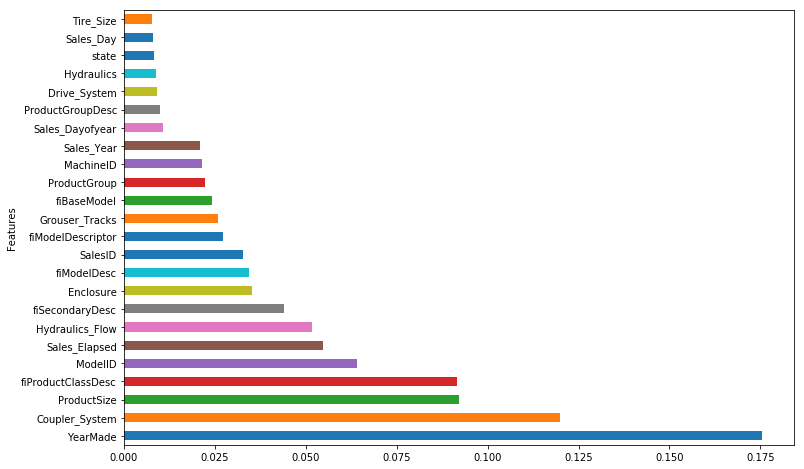

In [66]:
fi = rf_feat_imp(m, df_keep)
fi.plot('Features', "imp", 'barh',figsize=(12,8), legend=False)

## One-hot encoding

In [52]:
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
    m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [53]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_data(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11815669116170455, 0.23495856394284872, 0.9708222722801453, 0.9014105299262688, 0.910113258361064]


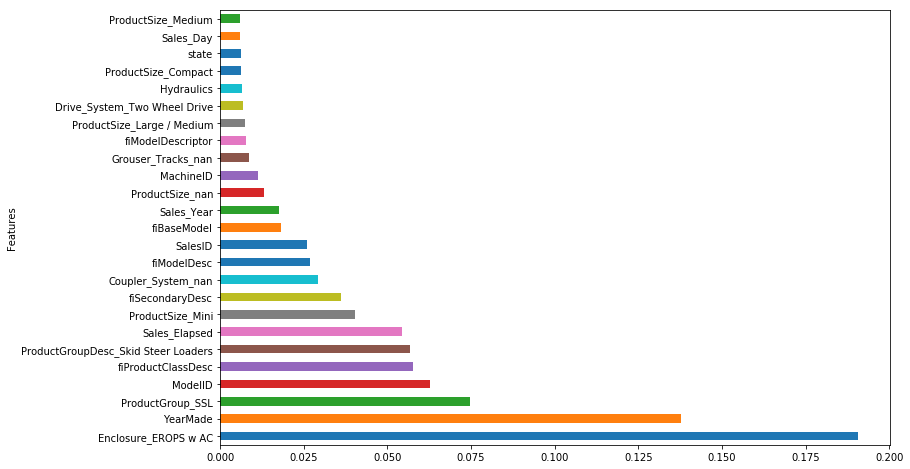

In [54]:
fi = rf_feat_imp(m, df_keep)
fi[:25].plot('Features', "imp", 'barh',figsize=(12,8), legend=False)

# Removing redundant features

In [63]:
from scipy.cluster import hierarchy as hc
import scipy

In [64]:
corr = np.round(df_keep.corr(method='spearman').values, 4) # Use rank correlation instead of correlation coefficient
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')

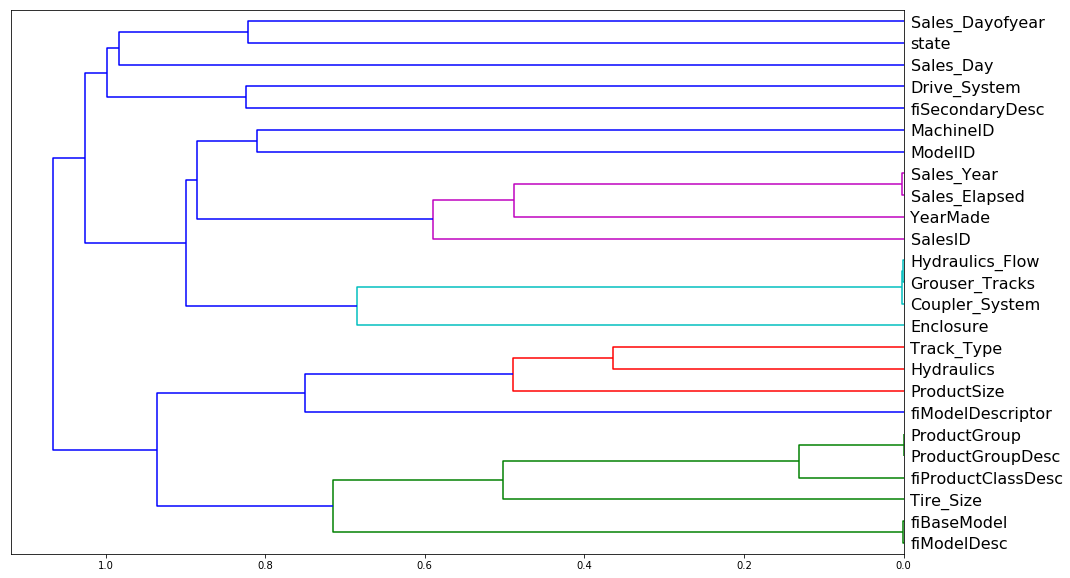

In [65]:
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [67]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_data(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [68]:
get_oob(df_keep)

0.8933580589908807

In [69]:
for i in ('Sales_Year', 'Sales_Elapsed', 'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System', 'fiBaseModel', 'fiModelDesc', 'ProductGroup', 'ProductGroupDesc'):
    print(i, get_oob(df_keep.drop(i, axis=1)))

Sales_Year 0.8926492643983207
Sales_Elapsed 0.8909853200726822
Hydraulics_Flow 0.8939805608592456
Grouser_Tracks 0.8934556275261417
Coupler_System 0.8933981994056244
fiBaseModel 0.8923949521573618
fiModelDesc 0.8925425077025282
ProductGroup 0.893084697393558
ProductGroupDesc 0.893563985163276


We can try one from each group for removal

In [70]:
get_oob(df_keep.drop(['Sales_Year', 'fiBaseModel', 'Grouser_Tracks','ProductGroupDesc'], axis=1))

0.8919445964513604

In [71]:
df_keep.drop(['Sales_Year', 'fiBaseModel', 'Grouser_Tracks','ProductGroupDesc'], axis=1, inplace=True)
X_train, X_valid = split_data(df_keep, n_trn)

No difference in OOB, so dropping the 3 features didnt improve the error but the simpler the better

In [72]:
reset_rf_samples()

In [73]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1257810894112554, 0.2267694803435047, 0.9669352281863233, 0.908163106722476, 0.9087024483340511]


# Partial dependence

In [67]:
from pdpbox import pdp
from plotnine import *

In [68]:
set_rf_samples(50000)

This is easier if we used 1-hot encoding

In [69]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_data(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

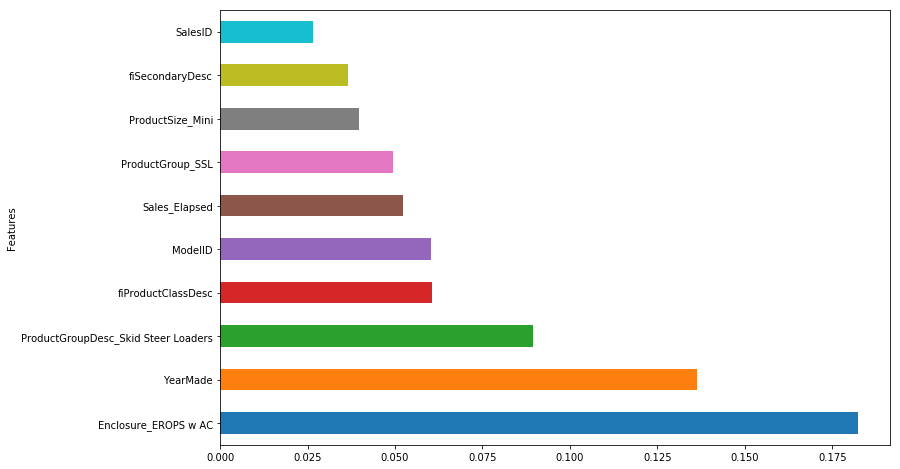

In [70]:
fi = rf_feat_imp(m, df_trn2)
fi[:10].plot('Features', 'imp', 'barh',figsize=(12,8), legend=False )

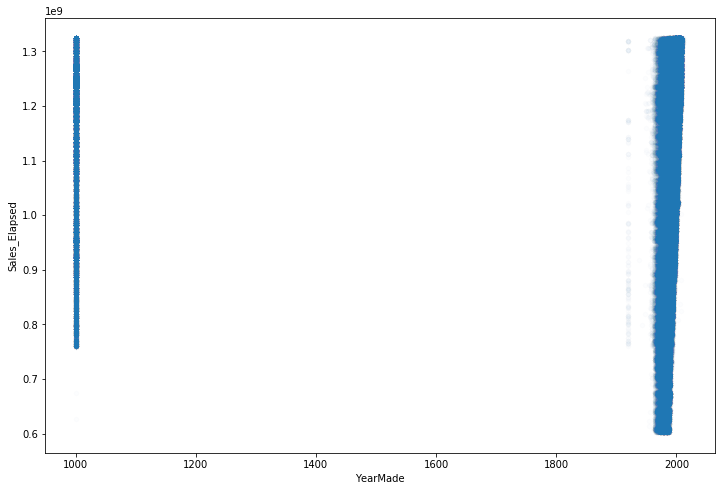

In [71]:
df_raw.plot('YearMade', 'Sales_Elapsed', 'scatter',figsize=(12,8), alpha=0.01)

In [72]:
x_all = get_sample(df_raw[df_raw.YearMade > 1930],  500)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\stats\smoothers.py:150: UserWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  warnings.warn("Confidence intervals are not yet implemented"


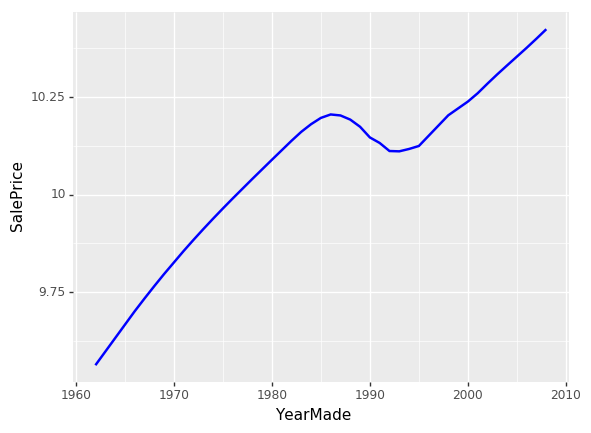

<ggplot: (30173097)>

In [73]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(colour='blue', se=True)

In [74]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [76]:
x_feat = list(x.columns)

In [77]:
p = pdp.pdp_isolate(model=m, dataset=x, model_features=x_feat, feature='YearMade')

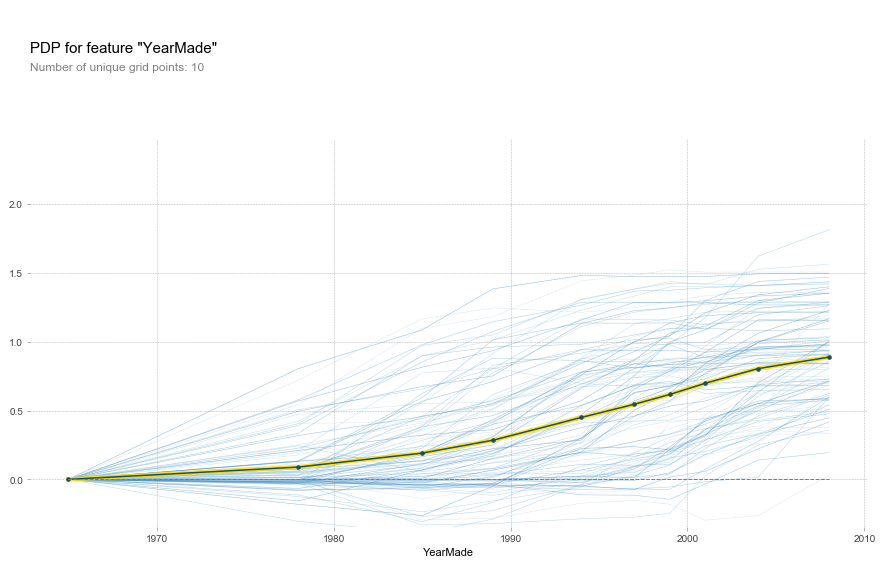

In [78]:
fig, axes = pdp.pdp_plot(p, 'YearMade', plot_lines=True, frac_to_plot=100)

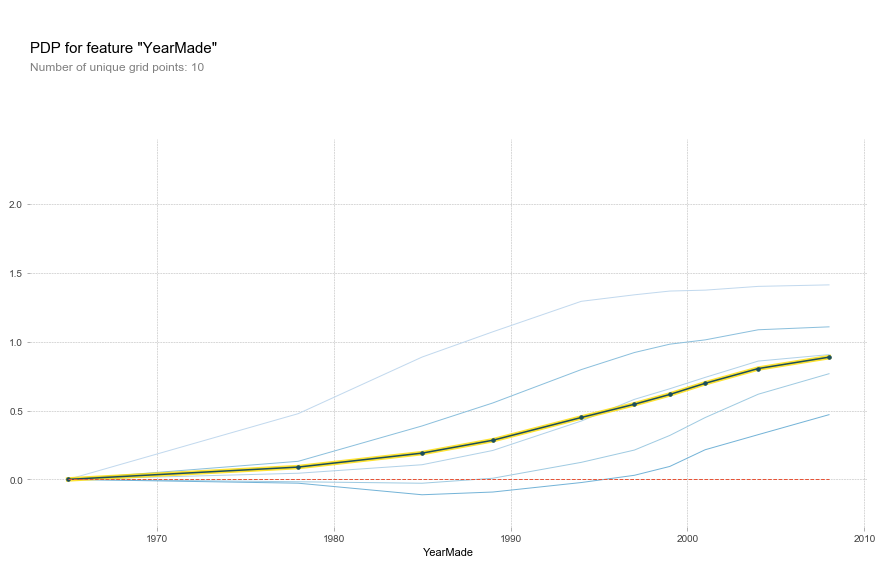

In [79]:
fig, axes = pdp.pdp_plot(p, 'YearMade', plot_lines=True, frac_to_plot=100, cluster=True, n_cluster_centers=5)

C:\Users\wfahme\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'N'
  s)


(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x10943940>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x633ef28>})

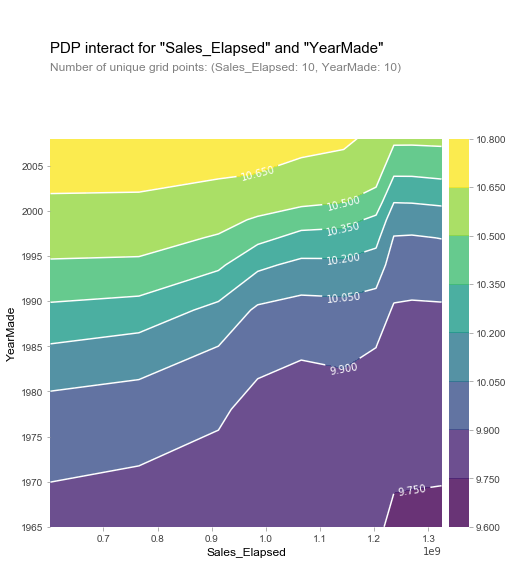

In [89]:
feats = ['Sales_Elapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x_feat, feats)
pdp.pdp_interact_plot(p, feats)

In [92]:
display_all(x.head())

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,fiProductClassDesc,state,Transmission,Hydraulics,Tire_Size,Undercarriage_Pad_Width,Stick_Length,Blade_Type,Sales_Year,Sales_Month,Sales_Week,Sales_Day,Sales_Dayofweek,Sales_Dayofyear,Sales_Is_month_end,Sales_Is_month_start,Sales_Is_quarter_end,Sales_Is_quarter_start,Sales_Is_year_end,Sales_Is_year_start,Sales_Elapsed,auctioneerID_na,MachineHoursCurrentMeter_na,UsageBand_High,UsageBand_Low,UsageBand_Medium,UsageBand_nan,ProductSize_Compact,ProductSize_Large,ProductSize_Large / Medium,ProductSize_Medium,ProductSize_Mini,ProductSize_Small,ProductSize_nan,ProductGroup_BL,ProductGroup_MG,ProductGroup_SSL,ProductGroup_TEX,ProductGroup_TTT,ProductGroup_WL,ProductGroup_nan,ProductGroupDesc_Backhoe Loaders,ProductGroupDesc_Motor Graders,ProductGroupDesc_Skid Steer Loaders,ProductGroupDesc_Track Excavators,ProductGroupDesc_Track Type Tractors,ProductGroupDesc_Wheel Loader,ProductGroupDesc_nan,Drive_System_All Wheel Drive,Drive_System_Four Wheel Drive,Drive_System_No,Drive_System_Two Wheel Drive,Drive_System_nan,Enclosure_EROPS,Enclosure_EROPS AC,Enclosure_EROPS w AC,Enclosure_NO ROPS,Enclosure_None or Unspecified,Enclosure_OROPS,Enclosure_nan,Forks_None or Unspecified,Forks_Yes,Forks_nan,Pad_Type_Grouser,Pad_Type_None or Unspecified,Pad_Type_Reversible,Pad_Type_Street,Pad_Type_nan,Ride_Control_No,Ride_Control_None or Unspecified,Ride_Control_Yes,Ride_Control_nan,Stick_Extended,Stick_Standard,Stick_nan,Turbocharged_None or Unspecified,Turbocharged_Yes,Turbocharged_nan,Blade_Extension_None or Unspecified,Blade_Extension_Yes,Blade_Extension_nan,Blade_Width_12',Blade_Width_13',Blade_Width_14',Blade_Width_16',Blade_Width_<12',Blade_Width_None or Unspecified,Blade_Width_nan,Enclosure_Type_High Profile,Enclosure_Type_Low Profile,Enclosure_Type_None or Unspecified,Enclosure_Type_nan,Engine_Horsepower_No,Engine_Horsepower_Variable,Engine_Horsepower_nan,Pushblock_None or Unspecified,Pushblock_Yes,Pushblock_nan,Ripper_Multi Shank,Ripper_None or Unspecified,Ripper_Single Shank,Ripper_Yes,Ripper_nan,Scarifier_None or Unspecified,Scarifier_Yes,Scarifier_nan,Tip_Control_None or Unspecified,Tip_Control_Sideshift & Tip,Tip_Control_Tip,Tip_Control_nan,Coupler_Hydraulic,Coupler_Manual,Coupler_None or Unspecified,Coupler_nan,Coupler_System_None or Unspecified,Coupler_System_Yes,Coupler_System_nan,Grouser_Tracks_None or Unspecified,Grouser_Tracks_Yes,Grouser_Tracks_nan,Hydraulics_Flow_High Flow,Hydraulics_Flow_None or Unspecified,Hydraulics_Flow_Standard,Hydraulics_Flow_nan,Track_Type_Rubber,Track_Type_Steel,Track_Type_nan,Thumb_Hydraulic,Thumb_Manual,Thumb_None or Unspecified,Thumb_nan,Pattern_Changer_No,Pattern_Changer_None or Unspecified,Pattern_Changer_Yes,Pattern_Changer_nan,Grouser_Type_Double,Grouser_Type_Single,Grouser_Type_Triple,Grouser_Type_nan,Backhoe_Mounting_None or Unspecified,Backhoe_Mounting_Yes,Backhoe_Mounting_nan,Travel_Controls_1 Speed,Travel_Controls_2 Pedal,Travel_Controls_Differential Steer,Travel_Controls_Finger Tip,Travel_Controls_Lever,Travel_Controls_None or Unspecified,Travel_Controls_Pedal,Travel_Controls_nan,Differential_Type_Limited Slip,Differential_Type_Locking,Differential_Type_No Spin,Differential_Type_Standard,Differential_Type_nan,Steering_Controls_Command Control,Steering_Controls_Conventional,Steering_Controls_Four Wheel Standard,Steering_Controls_No,Steering_Controls_Wheel,Steering_Controls_nan
45,1139423,999442,3217,121,3.0,2003,1788.0,1288,375,167,0,0,41,9,0,4,0,0,0,0,2006,12,50,14,3,348,False,False,False,False,False,False,1166054400,False,False,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
868,1142134,1039915,615,121,3.0,1999,11245.0,

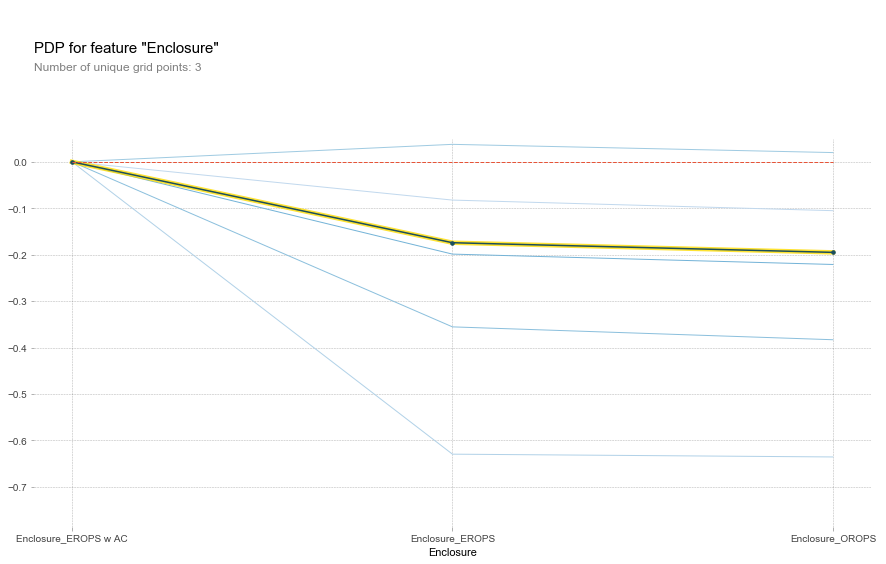

In [100]:
feat = ['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS']
p = pdp.pdp_isolate(model=m, dataset=x, model_features=x_feat, feature=feat)
fig, axes = pdp.pdp_plot(p, 'Enclosure' , cluster=True, n_cluster_centers=5, plot_lines=True, frac_to_plot=100)

# Tree Interpreter

In [102]:
from treeinterpreter import treeinterpreter as ti